<!-- P.S. this kernel only specifies which features are to be selected for modelling part you can check my [other kernel](https://www.kaggle.com/code/ashaykatrojwar/eda-pca-bayesian-gaussian-mixture). -->

# Importing Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import RobustScaler,PowerTransformer
from sklearn.mixture import BayesianGaussianMixture,GaussianMixture
from sklearn.metrics import confusion_matrix, silhouette_score, calinski_harabasz_score, davies_bouldin_score,balanced_accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
from matplotlib import pyplot as plt
import lightgbm as lgb

# Reading Data
*  Dropping id column.
*  Features f_07 to f_13 are `integer features`.
*  Other features are `continuous features`. 

In [2]:
df=pd.read_csv("../input/tabular-playground-series-jul-2022/data.csv")
df=df.drop('id',axis=1)
ss=pd.read_csv("../input/tabular-playground-series-jul-2022/sample_submission.csv")

# Feature distribution EDA
> The important takeaways from the distributions are:
   * All the continuous features are `normally distributed`.
   * Data needs to Transformed by using transformer such as `Power Transformer`.

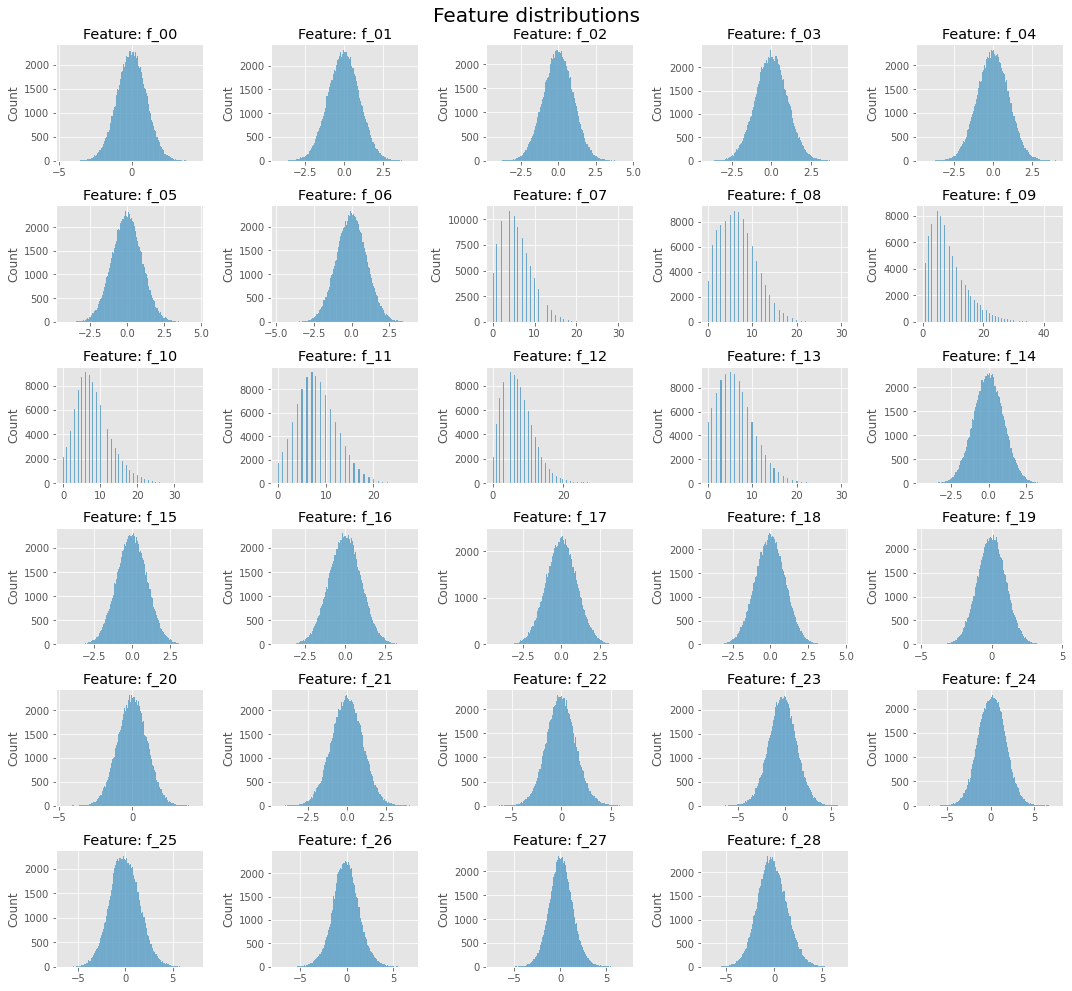

In [3]:
fig=plt.figure(figsize=(15,14))
for i, f in enumerate(df.columns):
    # New subplot
    plt.style.use('ggplot')
    plt.subplot(6,5,i+1)
    sns.histplot(x=df[f])
    plt.title(f'Feature: {f}')
    plt.xlabel('')
    
fig.suptitle('Feature distributions',  size=20)
fig.tight_layout()  
plt.show()

# Data Preprocessing
>  Preprocessing data using `Power Transformer`

In [4]:
r=PowerTransformer()
X=r.fit_transform(df)
df=pd.DataFrame(X,columns=df.columns)

# Outliers by Inter Quartile Range Method
IQR tells us the variation in the data set.Any value, which is beyond the range of `-1.5 IQR to 1.5 IQR` treated as outliers

> * Q1 represents the `1st quartile/25th percentile` of the data.
> * Q2 represents the `2nd quartile/median/50th percentile` of the data.
> * Q3 represents the `3rd quartile/75th percentile` of the data.
> * `(Q1–1.5*IQR)` represent the smallest value in the data set and `(Q3+1.5*IQR)` represnt the largest value in the data set.

By the below plot it can be observed that feature `f_26` has ~1600 outliers which is highest compared to other features but it's only `1.63%`of entire data of that feature which is not that significant. 

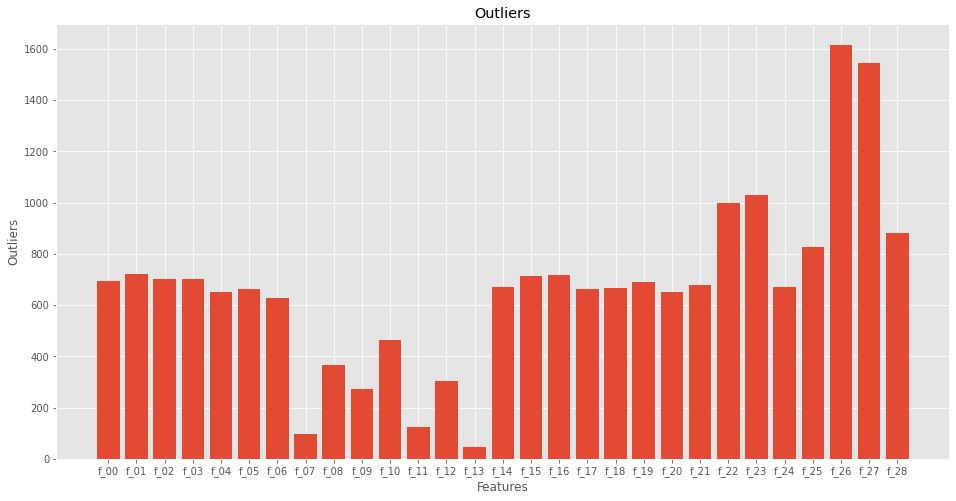

In [5]:
out=[]
def iqr_outliers(df,ft):
    q1 = df[ft].quantile(0.25)
    q3 = df[ft].quantile(0.75)
    iqr = q3-q1
    Lower_tail = q1 - 1.5 * iqr
    Upper_tail = q3 + 1.5 * iqr
    c=0
    for i in range(len(df[ft])):
        if df[ft][i] > Upper_tail or df[ft][i] < Lower_tail:
            c+=1
    return c
od={ f:iqr_outliers(df,f) for f in df.columns }

# Plotting Outliers
plt.style.use('ggplot')
plt.figure(figsize=(16,8))
plt.bar(x=od.keys(),height=od.values())
plt.xlabel("Features")
plt.ylabel("Outliers")
plt.title('Outliers')
plt.show()

# MODEL
You can check my [other kernel](https://www.kaggle.com/code/ashaykatrojwar/eda-pca-bayesian-gaussian-mixture) which has in depth analysis of how to choose `number of clusters` for our model and `Dimensionality reduction using PCA`.


In [6]:
BGM = BayesianGaussianMixture(n_components=7,covariance_type='full',random_state=1,n_init=5,tol=0.01)
# fit model and predict clusters
preds = BGM.fit_predict(X)
pp=BGM.predict_proba(X)

# Useful Features
> From the plot of cluster means plotted from "BayesianGaussianMixture" model it is clear that features from `f_0 to f_06` and features from `f_14 to f_21` are of not much of use so we can drop these features. 

> `Useful features are` ****['f_07', 'f_08',
>        'f_09', 'f_10', 'f_11', 'f_12', 'f_13', 'f_22', 'f_23', 'f_24', 'f_25', 'f_26',
>        'f_27', 'f_28']****

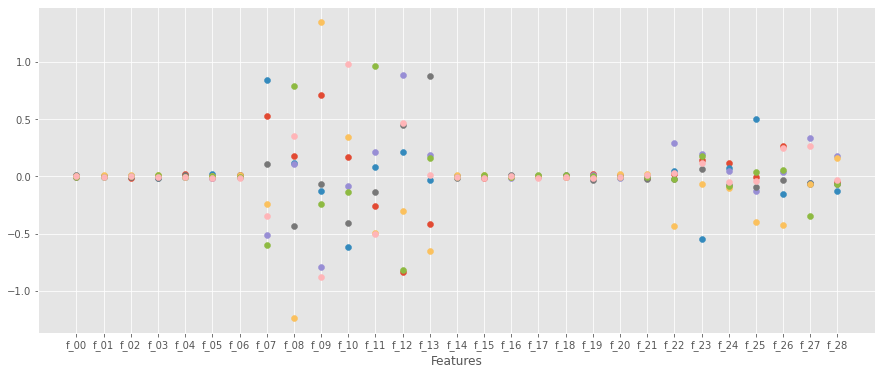

In [7]:
plt.style.use('ggplot')
plt.figure(figsize=(15,6))
for i in range(BGM.means_.shape[0]):
    plt.scatter(np.arange(X.shape[1]), BGM.means_[i])
plt.xticks(ticks=np.arange(X.shape[1]), labels=df.columns)
plt.xlabel('Features')
plt.show()

In [8]:
feats=['f_07', 'f_08', 'f_09', 'f_10', 'f_11', 'f_12', 'f_13', 'f_22', 'f_23', 'f_24', 'f_25', 'f_26', 'f_27', 'f_28']

# Classifier
> After creating a data from clusters predicted by Bayessian Gaussian Mixture model, a `LGBM classifier` is trained on same data but only on data points having cluster prediction probability more than `70%`.
> Code below is inspired form [@aldparis](https://www.kaggle.com/adaubas)

In [9]:
df[[f'predict_proba_{i}' for i in range(7)]]=pp # creating new dataframe columns of probabilites 
df['predict_proba']=np.max(pp,axis=1)
df['predict']=np.argmax(pp,axis=1)
    
trn_indx=np.array([])
for n in range(7):
    # using only those index whoose predicted probablity > 70
    indx=df[(df.predict==n) & (df.predict_proba > 0.70)].index 
    trn_indx = np.concatenate((trn_indx, indx))
    
X = df.loc[trn_indx][feats]
y = df.loc[trn_indx]['predict']

In [10]:
params_lgb = {'learning_rate': 0.07,'objective': 'multiclass','boosting': 'gbdt','verbosity': -1,'n_jobs': -1, 'num_classes':7} 

lgbm_predict_proba = 0  
classif_scores = []

gkf = StratifiedKFold(10, shuffle=True, random_state = 1)
for fold, (trn, val) in enumerate(gkf.split(X,y)):   

    X_trn = lgb.Dataset(X.iloc[trn], y.iloc[trn], feature_name = feats)
    X_val = lgb.Dataset(X.iloc[val], y.iloc[val], feature_name = feats)
    
    model = lgb.train(params = params_lgb, 
                train_set = X_trn, valid_sets =  X_val, 
                num_boost_round = 5000, 
                callbacks = [ lgb.early_stopping(stopping_rounds=100, verbose=True), lgb.log_evaluation(period=200)])  
    
    y_pred_proba = model.predict(X.iloc[val])
    y_pred = np.argmax(y_pred_proba, axis=1)
    
    s = (balanced_accuracy_score(y.iloc[val], y_pred),
        roc_auc_score(y.iloc[val], y_pred_proba, average="weighted", multi_class="ovo"))
    classif_scores.append(s)

    lgbm_predict_proba += model.predict(df[feats]) / 10
    
pd.DataFrame(classif_scores, columns = ["balanced_accuracy_score", "roc_auc_score"]).mean(0)

Training until validation scores don't improve for 100 rounds
[200]	valid_0's multi_logloss: 0.04823
[400]	valid_0's multi_logloss: 0.0297414
[600]	valid_0's multi_logloss: 0.0257567
[800]	valid_0's multi_logloss: 0.0253892
Early stopping, best iteration is:
[856]	valid_0's multi_logloss: 0.0252758
Training until validation scores don't improve for 100 rounds
[200]	valid_0's multi_logloss: 0.041915
[400]	valid_0's multi_logloss: 0.0266396
[600]	valid_0's multi_logloss: 0.0236453
[800]	valid_0's multi_logloss: 0.024015
Early stopping, best iteration is:
[703]	valid_0's multi_logloss: 0.0232475
Training until validation scores don't improve for 100 rounds
[200]	valid_0's multi_logloss: 0.0449658
[400]	valid_0's multi_logloss: 0.0277427
[600]	valid_0's multi_logloss: 0.0237268
[800]	valid_0's multi_logloss: 0.0234037
Early stopping, best iteration is:
[867]	valid_0's multi_logloss: 0.0231365
Training until validation scores don't improve for 100 rounds
[200]	valid_0's multi_logloss: 0.046

balanced_accuracy_score    0.990308
roc_auc_score              0.999922
dtype: float64

# Confusion Matrix of LGBM and actual Gaussian Mixture Model

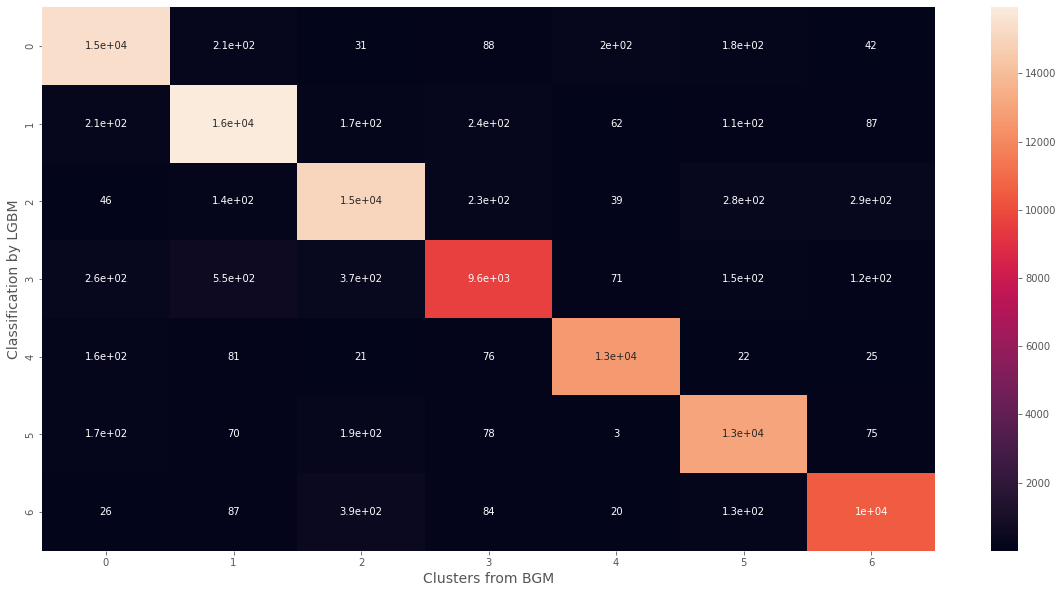

In [11]:
# confusion_matrix(df.predict, np.argmax(lgbm_predict_proba,axis=1))
plt.figure(figsize=(20,10))
sns.heatmap(confusion_matrix(df.predict, np.argmax(lgbm_predict_proba,axis=1)), annot=True)
plt.xlabel("Clusters from BGM",fontsize=14)
plt.ylabel('Classification by LGBM',fontsize=14)
plt.show()

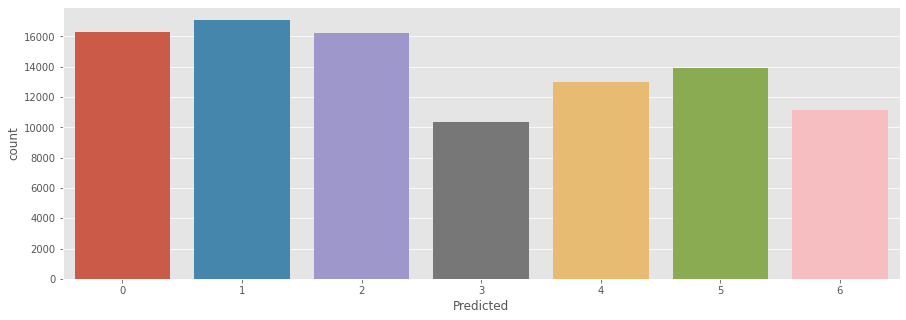

In [12]:
ss.Predicted=np.argmax(lgbm_predict_proba,axis=1)
ss.to_csv("submission.csv",index=False)

plt.figure(figsize=(15,5))
sns.countplot(x=ss.Predicted)
plt.show()
